Northwestern MSiA 432 Deep learning 
    Assignment #2 starter code, Spring 2019.
    
    This code demonstrates the use of transfer learning to speed up
    the training process for a convolutional neural network.
    
    Notes:
        - Heatmaps may appear black in the first few epochs. Wait until accuracy improves.
        - The native image size is 224x224 for VGG, resize/crop your images to match
        - Filter visualization is slow, change vizfilt_timeout for more speed or accuracy
        - Be sure to rename/delete the basepath when changing model parameters, e.g. layers or random labels

In [134]:
import numpy as np
import os
import glob
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
date="05092019" #defining the date for saving files later
wd= os.getcwd()

In [136]:
allyes=glob.glob("../data/raw/yes/"+'*.[pjJ][npP][gG]') #grabs all jpg and png files
allno=glob.glob("../data/raw/no/"+'*.[pjJ][npP][gG]')
#can load with:
X=np.load("../data/processed/%s_X.npy"%(date))
y=np.load("../data/processed/%s_y.npy"%(date))

In [137]:
X.shape

(253, 400, 400, 3)

In [138]:
# X.shape

In [139]:
# import cv2
# imlist=[]
# #filename = 'your_image.jpg'
# W = 224.
# #oriimg = cv2.imread(filename,cv2.CV_LOAD_IMAGE_COLOR)
# for image in X:
#     height, width, depth = image.shape
#     imgScale = W/width
#     newX,newY = image.shape[1]*imgScale, image.shape[0]*imgScale
#     newimg = cv2.resize(image,(int(newX),int(newY)))
#     imlist.append(newimg)
# X=np.array(imlist)
# y = y.astype('float32')

In [140]:
# resX=[]
# xres = 224
# yres = 224
# resizeval = (xres,yres)
# # resize and convert to grayscale
# for img in X:
#     img = cv2.resize(img,resizeval)
# #     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# #     img_expanded = gray[:, :, np.newaxis]
# #     #print(img_expanded.shape)

# #     print(gray.shape)
# #     gray = img.reshape((len(gray), -1)).T
# #     print(gray.shape)
#     resX.append(img)

# resX = np.array(resX)
# #resX = resX.reshape((len(resX), -1)).T
# #resX = resX.reshape(xres,yres, 1)

# X = resX
# #y = y.T
# y = y.astype('float32')

In [141]:
#see which pid you are am
import os
os.getpid()

19689

In [144]:
!nvidia-smi

Fri May 31 15:27:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:02:00.0 Off |                    0 |
| 32%   70C    P0    71W / 235W |  11019MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [143]:
# import tensorflow as tf
# tfconfig = tf.ConfigProto()
# tfconfig.gpu_options.allow_growth = True
# sess = tf.Session()
# sess.close()

In [75]:
# ##change gpus 
# ###NOTE: this needs to be run before importing tensorflow. 
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [76]:
# #%% ------ CPU/GPU memory fix -------
# import tensorflow as tf, keras.backend.tensorflow_backend as ktf
# def get_session(gpu_fraction=0.45):
#     gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction, allow_growth=True)
#     return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# ktf.set_session(get_session())

In [121]:
# Show devices
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print([x.name for x in local_device_protos])

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


In [123]:

import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print("Tensorflow Version:", tf.__version__)
print(tf.keras.__version__)
print(get_available_gpus())

Tensorflow Version: 1.13.1
2.2.4-tf
['/device:GPU:0']


In [79]:
# ##change gpus
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

# imports and function definitions

In [80]:
# #may need to install a older scipy version as some functions require it
# !pip install --ignore-installed --user scipy==1.2.1 

In [125]:
# Obligatory imports
from IPython.display import display 
from PIL import Image
import imageio

import os, time, numpy as np, scipy, random, pandas as pd, socket, warnings
import matplotlib.pyplot as plt
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # Workaround for Mac
%matplotlib inline

In [82]:
# Set project configuration

def change_basepath(folder_name=None):
    """
    GE added, makes it easy to specify a folder extention that will be created onto basepath. if folder_name==None, then basepath will be reset to it's origional value.
    """
    
    basepath= "../data"
    
    if folder_name != None:
        address = os.path.join(basepath, folder_name)
    else:
        address = basepath
    if not os.path.exists(address):
        os.makedirs(address)
    return(address)
basepath= change_basepath()


In [83]:
# VGG net definition starts here. Change the vggblocks to set how many blocks to transfer
def make_vgg():
    from keras.models import Model
    from keras.regularizers import l1_l2
    from keras.layers import Flatten, Dense, Input, Convolution2D, MaxPooling2D, BatchNormalization
    from keras.layers.advanced_activations import LeakyReLU
    
    img_input = Input(shape=tsize)
    if vggblocks == 0: x = img_input 
    if vggblocks >= 1: # Block 1
        x = LeakyReLU(alpha)(Convolution2D(64, (3, 3), padding='same', name='block1_conv1')(img_input))
        x = LeakyReLU(alpha)(Convolution2D(64, (3, 3), padding='same', name='block1_conv2')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
    if vggblocks >= 2: # Block 2
        x = LeakyReLU(alpha)(Convolution2D(128, (3, 3), padding='same', name='block2_conv1')(x))
        x = LeakyReLU(alpha)(Convolution2D(128, (3, 3), padding='same', name='block2_conv2')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
    if vggblocks >= 3: # Block 3
        x = LeakyReLU(alpha)(Convolution2D(256, (3, 3), padding='same', name='block3_conv1')(x))
        x = LeakyReLU(alpha)(Convolution2D(256, (3, 3), padding='same', name='block3_conv2')(x))
        x = LeakyReLU(alpha)(Convolution2D(256, (3, 3), padding='same', name='block3_conv3')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
    if vggblocks >= 4: # Block 4
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block4_conv1')(x))
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block4_conv2')(x))
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block4_conv3')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
    if vggblocks >= 5: # Block 5
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block5_conv1')(x))
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block5_conv2')(x))
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block5_conv3')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
        
    x = Flatten(name='flatten')(x)
    for i in range(fclayers): x = LeakyReLU(alpha)(Dense(fclayersize, kernel_regularizer=l1_l2(l1_reg, l2_reg))(x))
    x = Dense(len(obj_classes), activation='softmax', name='predictions')(x)
    
    inputs = img_input
    model = Model(inputs, x, name='vgg16')
    
    # VGG Transfer weights
    from keras.applications import vgg16
    import keras.layers.convolutional
    vgg16model = vgg16.VGG16(include_top=False)
    modelconv = [l for l in model.layers if type(l) == keras.layers.convolutional.Conv2D]
    vgg16conv = [l for l in vgg16model.layers if type(l) == keras.layers.convolutional.Conv2D]
    
    for i, l in enumerate(modelconv):
        if i > xferlearning: continue # Transfer only first n layers
        print('**** Transferring layer %d: %s from VGG ****' % (i, l))
        weights = vgg16conv[i].get_weights()
        modelconv[i].set_weights(weights)
        if freeze_conv: l.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model, img_input

In [84]:
#%% resnet50 definition
def make_resnet50():
    #The default input size for this model is 224x224.
    #This model and can be built both with 'channels_first' data format (channels, height, width) 
    #or 'channels_last' data format (height, width, channels).
    import keras
    from keras.models import Model
    from keras.layers import Dense, GlobalAveragePooling2D, Dropout
    #from keras_applications.resnet import ResNet50
    from keras.applications import ResNet50
    from keras.regularizers import l1
    
    xmodel = ResNet50(include_top=False,
#                                        weights='imagenet',
#                                        input_tensor=None,
#                                        input_shape=None,
#                                        pooling=None,
                                       classes=10)

    #xmodel = keras.applications.Xception(include_top=False) 
#   xmodel =keras.applications.resnet50(include_top=False)
    x = xmodel.output
    #for layer in xmodel.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, kernel_regularizer=l1(1e-7))(x)
    predictions = Dense(len(obj_classes), activation='softmax')(x)
    
    model = Model(inputs=xmodel.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
    model.summary()
    return model, xmodel.input

In [85]:
# #%% resnet50 definition noweight
# def make_resnet50_noweight():
#     #The default input size for this model is 224x224.
#     #This model and can be built both with 'channels_first' data format (channels, height, width) 
#     #or 'channels_last' data format (height, width, channels).
#     import keras
#     from keras.models import Model
#     from keras.layers import Dense, GlobalAveragePooling2D, Dropout
#     #from keras_applications.resnet import ResNet50
#     from keras.applications import ResNet50
#     from keras.regularizers import l1
    
#     xmodel = ResNet50(include_top=False,
#                                        weights=None,
# #                                        input_tensor=None,
# #                                        input_shape=None,
# #                                        pooling=None,
#                                        classes=10)

#     #xmodel = keras.applications.Xception(include_top=False) 
# #   xmodel =keras.applications.resnet50(include_top=False)
#     x = xmodel.output
#     #for layer in xmodel.layers: layer.trainable = False
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.5)(x)
#     x = Dense(256, kernel_regularizer=l1(1e-7))(x)
#     predictions = Dense(len(obj_classes), activation='softmax')(x)
    
#     model = Model(inputs=xmodel.input, outputs=predictions)
#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
#     model.summary()
#     return model, xmodel.input

In [86]:
#%% Xception definition
def make_xception():
    import keras
    from keras.models import Model
    from keras.layers import Dense, GlobalAveragePooling2D, Dropout
    from keras.regularizers import l1
    xmodel = keras.applications.Xception(include_top=False) #keras.applications.resnet50 to change it
    x = xmodel.output
    #for layer in xmodel.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, kernel_regularizer=l1(1e-7))(x)
    predictions = Dense(len(obj_classes), activation='softmax')(x)
    
    model = Model(inputs=xmodel.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
    model.summary()
    return model, xmodel.input

# Image Import, Scaling, Batching options

In [87]:
#########  CHANGE IMSIZE, BATCHSIZE HERE #########
imsize        = (224, 224) # n x n square images, VGG default is 224x224. Remember to change this.
tsize         = imsize + (3,) #for 3 color channels
batch_size, nb_epoch = 32, 10000 # Change for early stopping regularization. 
#changed batchsize from #32 to 253
#########  ****************************** #########


#image path specification
trainfolder   = '../data/train'#os.path.join(basepath, 'train')
testfolder    = '../data/test'#os.path.join(basepath, 'test')


#%% Create demo data
def makedata(basepath):
    from keras.datasets import cifar10
    from keras.utils.generic_utils import Progbar    
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    obj_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 
    for (X_data, y_data, bp) in [(X_train, y_train, trainfolder), (X_test, y_test, testfolder)]:
        if os.path.exists(bp): return
        for c in obj_classes: os.makedirs(os.path.join(bp, c), exist_ok=True)
        pb = Progbar(len(y_data), interval=1)
        print('\nMaking data folder')
        for i, (im, lbl) in enumerate(zip(X_data, y_data)):
            pn = os.path.join(bp, obj_classes[int(lbl)], "%d.png" % i)
            pb.update(i)
            if not os.path.exists(pn): imageio.imwrite(pn, im)#scipy.misc.imsave(pn, im)

In [88]:
# makedata(basepath) # Comment out this line to use your own data

# Load data
from keras.preprocessing.image import ImageDataGenerator
# ##middleground data aug
# datagen = ImageDataGenerator(
#     rescale=1./255,                         # rescale data
#     shear_range=0.2,
#     zoom_range=0.2,    
#     rotation_range=0.10,    #0                   # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.1,  #0              # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1, #0                 # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,                   # randomly flip images
#     vertical_flip=False)                    # randomly flip images

#no data aug
datagen = ImageDataGenerator(
    rescale=1./255,                         # rescale data
    shear_range=0.0,
    zoom_range=0.0,    
    rotation_range=0.0,    #0                   # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.0,  #0              # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0, #0                 # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,                   # randomly flip images
    vertical_flip=False)                    # randomly flip images


# ##lots of data aug
# datagen = ImageDataGenerator(
#     rescale=1./255,                         # rescale data
#     shear_range=0.7,
#     zoom_range=0.7,    
#     rotation_range=0.7,    #0                   # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.7,  #0              # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.7, #0                 # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,                   # randomly flip images
#     vertical_flip=True)                    # randomly flip images


train_generator = datagen.flow_from_directory(
        trainfolder,
        target_size=imsize,
        batch_size=batch_size #changd 
)

test_generator = datagen.flow_from_directory(
        testfolder,
        target_size=imsize,
        batch_size=-1)

X_test, Y_test = test_generator.next()

obj_classes = sorted(train_generator.class_indices.keys())
class_to_idx = dict([(y, x) for (x,y) in enumerate(obj_classes)])
img_rows, img_cols, img_channels = X_test.shape[1:]


Found 204 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [107]:
obj_classes

['False', 'True']

In [109]:
train_generator

## visualization functions

In [90]:
#%% Visualization code
def viz_losses(stats): 
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    epoch = len(stats)
    convlayers = len([l.name for l in model.layers if 'conv' in l.name])
    blocks     = len(set([l.name.split('_')[0] for l in model.layers if 'block' in l.name]))
    dense      = len([l.name for l in model.layers if 'dense' in l.name])
    fcsize     = model.layers[-1].input_shape[1]
    fig.suptitle("Training %s blocks=%d, conv=%d, dense=%d, fcsize=%d, epoch=%d" % (model.name, blocks, convlayers, dense, fcsize, epoch))
    ax1.plot(stats['Train loss'].values, label='Train loss', color='blue')
    ax1.plot(stats['Test loss'].values, label='Test loss', color='green')
    ax1.set_yscale('log')
    ax2.plot(stats['Accuracy'].values, label='Test accuracies', color='red')
    ax2.plot(stats['Train accuracy'].values, label='Train accuracies', color='blue')
    ax2.axhline(1.0/len(obj_classes), linestyle='dashed', color='gray')
    dataset = pd.Series(train_generator.classes)
    chance = dataset.value_counts().max() / dataset.value_counts().sum()
    ax2.text(0, chance, 'Chance')
    ax2.axhline(np.max(stats['Accuracy']), linestyle='dashed', color='red')
    ax2.text(0, np.max(stats['Accuracy']), 'Best')    
    ax2.set_ylim([0, 1])
    ax2.set_title('Accuracy: %0.2f%%' % (100.0*stats['Accuracy'].values[-1]))     
    ax1.legend(), ax2.legend()
    plt.savefig(os.path.join(basepath, 'loss-%s.png' % modelarch))
    plt.show()    
    plt.close()

In [91]:
#%% Explanations
import skimage.exposure, skimage.filters
from skimage.color import gray2rgb
from keras import backend as K

def hide_axes(ax): ax.set_xticks([]), ax.set_yticks([])
class Heatmap:
    def __init__(self, model, obj_classes):
        self.obj_classes = obj_classes
        self.nclasses    = len(obj_classes)
        self.model       = model
    
    def make_masks(self, im, n=8, maskval=0.1):
        masks = []
        xwidth, ywidth = int(np.ceil(im.shape[0]/n)), int(np.ceil(im.shape[1]/n))
        for i in range(n):
            for j in range(n):
                mask = np.ones(im.shape[:2])
                mask[(i*xwidth):((i+1)*xwidth), (j*ywidth):((j+1)*ywidth)] = maskval
                mask = skimage.filters.gaussian(mask, 1) # Change this for local mask smoothing
                masks.append(mask)
        return np.array(masks)

    def get_slice_masks(self, im, n_segments=16, blur=0.03):
        from skimage.segmentation import slic
        segments = slic(im, n_segments=n_segments, sigma=5)
        masks = []
        # loop over the unique segment values
        for (i, segVal) in enumerate(np.unique(segments)):
            # construct a mask for the segment
            mask = np.zeros(im.shape[:2], dtype="float32")
            mask[segments == segVal] = 1
            mask = skimage.filters.gaussian(mask, im.shape[1]*blur) # Change this for local mask smoothing            
            masks.append(mask)
        return np.array(masks), segments
        
    def explain_prediction_heatmap(self, im, actual):
        ##ge added start##
        global trainstats
        ##ge added end#
        import skimage.color
        def hsv_fn(im): return skimage.color.hsv2rgb(im) if hsv else im
        plt.imshow(hsv_fn(im), interpolation='bilinear'), plt.xticks([]), plt.yticks([]), plt.title('Full image'), plt.show(), plt.close()
        masks = np.concatenate([self.make_masks(im, n=i) for i in (9, 7, 5, 3, 2)])
        #masks, segments = self.get_slice_masks(im)        
        masknorm = masks.sum(axis=0)
        heatmaps = np.zeros((self.nclasses,) + im.shape[:2])
        for m in masks:
            prediction = self.model.predict(np.expand_dims(im*gray2rgb(m), 0))
            for c in range(self.nclasses):
                heatmaps[c] += (prediction[0][c]*m)
        for h in heatmaps: h = h / masknorm
        fig, axes = plt.subplots(2, self.nclasses + 1, figsize=(20, 5))
        #axes[0,0].imshow(hsv(im)), axes[1,0].imshow(mark_boundaries(im, segments))        
        axes[0,0].imshow(hsv_fn(im)), axes[1,0].imshow(im)        
        
        axes[0,0].set_title(actual)
        axes[1,0].set_title('HSV' if hsv else 'RGB')        
        hide_axes(axes[0,0]), hide_axes(axes[1,0])       
        predictions = np.sum(heatmaps, axis=(1,2,))
        predictions /= predictions.max()
        for n, i in enumerate(np.argsort(predictions)[::-1][:self.nclasses]):
            h = ((255 * heatmaps[i])/heatmaps[i].max()).astype('uint16')
            h = skimage.exposure.equalize_adapthist(h)            
            h = skimage.filters.gaussian(h, 1) # Change this for global mask smoothing
            axes[0, n+1].imshow(gray2rgb(h))
            axes[1, n+1].imshow(gray2rgb(h) * hsv_fn(im) * (0.5 + 0.5*predictions[i]))  
            hide_axes(axes[0, n+1]), hide_axes(axes[1, n+1])        
            axes[0, n+1].set_title(self.obj_classes[i] + ': %0.1f%%' % (100*predictions[i]/predictions.sum()))
        fig.tight_layout()
        ##ge modify: added e to heatmapfilename and text inserted the len(trainstats)=epoch number ##
        plt.savefig(os.path.join(basepath, 'heatmap-e%05d.png') % len(trainstats))#np.random.randint(0, 99999))
        plt.show()
        plt.close()
        return heatmaps

In [92]:
#layer_dict = dict([(layer.name, layer) for layer in model.layers])

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x = x*0.1 + 0.5
    x = np.clip(x, 0, 1) * 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def viz_filter_max(layer_name, filter_index=0, max_steps=9999, timeout=3):
    from keras.utils.generic_utils import Progbar            
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, img_input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([img_input], [loss, grads])
    step = 1e-0
    input_img_data = np.random.random((1, img_rows, img_cols, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    tm = time.time()

    for i in range(max_steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if time.time() - tm > timeout:
            plt.text(0.1, 0.1, "Filter viz timeout: %d" % timeout, color='red')
            break
    img = input_img_data[0]
    img = deprocess_image(img)
    fig = plt.imshow(img)    
    hide_axes(fig.axes)
    return layer_output
    
def viz_filters(model, img_input, img_rows, img_cols, nbfilters=3, timeout=60):
    tm = time.time()
    print("Visualizing filters (CTRL-C to cancel)")
    try:         
        for layer_name in sorted(layer_dict.keys()):
            if time.time() - tm > timeout:
                print("Filter visualization timed out: %d. Change timeout in viz_filters()." % timeout)
                break
            if not hasattr(layer_dict[layer_name], 'filters'): continue
            nfilters = layer_dict[layer_name].filters
            fig, ax = plt.subplots(1, nbfilters, figsize=(8, 4))
            fig.suptitle("Layer %s has %d filters" % (layer_name, nfilters))            
            for j in range(nbfilters):
                plt.subplot(1, nbfilters, j + 1)
                viz_filter_max(layer_name, random.randint(0, nfilters-1), timeout=vizfilt_timeout)
            fig.tight_layout()    
            plt.savefig(os.path.join(basepath, 'filters-%s-%s.png' % (modelarch, layer_name))) 
            plt.show(), plt.close()
    except KeyboardInterrupt: return

In [93]:
def test_prediction(im, y):
    pred = model.predict(np.expand_dims(im, 0))
    cls = np.argmax(y)
    heatmap = Heatmap(model, obj_classes)                
    heatmap.explain_prediction_heatmap(im, obj_classes[cls])
    
    print("Actual: %s(%d)" % (obj_classes[cls], cls))
    for cls in list(reversed(np.argsort(pred)[0]))[:5]:
        conf = float(pred[0, cls])/pred.sum()
        print("    predicted: %010s(%d), confidence=%0.2f [%-10s]" % (obj_classes[cls], cls, conf, "*" * int(10*conf)))
    return pred

def confusion_matrix(model, X, T, accpct, save=False):
    ##GE modified to save##
    import seaborn
    global trainstats
    from sklearn.metrics import classification_report, confusion_matrix
    Y_pred = model.predict(X)
    y_pred = np.argmax(Y_pred, axis=1)
    y_test = np.argmax(T, axis=1)
    print('Confusion Matrix')
    data = confusion_matrix(y_test, y_pred)
    data = data / data.sum(axis=1)
    #print('Classification Report')
    #print(classification_report(y_test, y_pred, target_names=obj_classes))
    seaborn.set_style("whitegrid", {'axes.grid' : False})
    seaborn.heatmap(data, annot=data*100, fmt='0.0f', cmap='Wistia', xticklabels=obj_classes, yticklabels=obj_classes)
    plt.xlabel('Predicted'), plt.ylabel('Actual'), plt.title('Confusion matrix (ACC %0.2f%%)' % (accpct*100))
    if save==True and len(trainstats) in [1,epochs] :
        plt.savefig(os.path.join(basepath, 'conf-%s.png' % len(trainstats)))
    
    plt.show(), plt.close()

def tsne_viz(model, X, Y, accpct, n=500, save=False):
    ##GE modified to save##
    global X_embedded, xx, yy, d, predictions
    import sklearn.manifold, matplotlib.cm as cm
    predictions = model.predict(X)    
    colors = iter(cm.rainbow(np.linspace(0, 1, len(obj_classes))))
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(predictions[:n])
    for d in range(len(obj_classes)):
        xx = X_embedded[Y[:n][:, d] == 1, 0]
        yy = X_embedded[Y[:n][:, d] == 1, 1]
        plt.scatter(xx, yy, c=[next(colors)], label=obj_classes[d])
        t = plt.text(np.median(xx), np.median(yy), obj_classes[d], fontsize=24)
        t.set_bbox({'facecolor': 'white', 'alpha': 0.75})
    plt.title('T-SNE viz - Accuracy: %0.2f%%' % (accpct*100)), plt.legend()
    
    if save==True and len(trainstats) in [1,epochs] :
        plt.savefig(os.path.join(basepath, 'tsne-%s.png' % len(trainstats)))

In [117]:
##grand training visualization function
from keras.callbacks import Callback
class VizTraining(Callback):
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        tacc  = logs.get('val_acc')
        trainstats.loc[len(trainstats)] = (logs.get('loss'), logs.get('val_loss'), tacc, logs.get('acc')) 
        confusion_matrix(model, X_test, Y_test, tacc, save=True) ####change to save or not
        tsne_viz(model, X_test, Y_test, tacc, save=True) ####change to save or not
        viz_losses(trainstats)
        t_ind = random.randint(0, len(X_test) - 1)
        #t_ind=random.choice([35,36]) #changed to randomly choose between a pos and negative image
        ##
        test_prediction(X_test[t_ind], Y_test[t_ind])    
        if vizfilt_timeout > 0 and np.random.randint(0, 3) == 0: 
            viz_filters(model, img_input, img_rows, img_cols)
        if checkpoint: model.save(modelid, overwrite=True)
        print("Total training time: %0.2f min, epoch: %d" % ((time.time() - tm)/60.0, len(trainstats))) 
        print("Average time per epoch: %0.2f s" % ((time.time() - tm)/len(trainstats)))

35
[1. 0.]


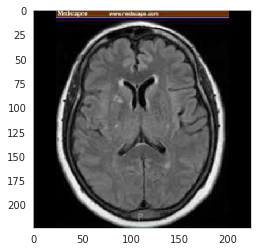

36
[0. 1.]


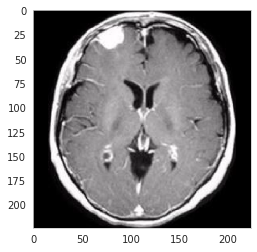

In [114]:
for i in range(0,len(X_test)):
    if i in [35, 36]:
        print(i)
        print(Y_test[i])
        plt.imshow(X_test[i])
        plt.show()
    
# #36
# #35

In [105]:
29

29

# example run:
## copy these two cells and make appropriate changes for each model

vgg with block=1, non-xfer learning, 25 epoch:

In [145]:
basepath= change_basepath('xception_noaug3') ####change

# Model settings    
vggblocks     = 3        # Number of VGG blocks to create, 0-5 blocks
xferlearning  = 2      # Enable transfer learning up to layer n (max 12, -1 = off)
freeze_conv   = False    # Freeze convolutional layers
fclayersize   = 64#128      # Size of fully connected (FC) layers
fclayers      = 1        # Number of FC layers
fcdropout     = 0.0      # Dropout regularization factor for FC layers
alpha         = 0.0      # Leaky ReLU alpha
l1_reg        = 0.0      # L1 regularization for FC
l2_reg        = 0.0      # L2 regularization for FC

# Optimizer settings
optimizer = Adam()   
# batch_size, nb_epoch = 32, 10000 # Change for early stopping regularization
batchnorm     = True     # Batch normalization
checkpoint    = True     # Checkpoint models to continue training

# Visualization settings
hsv             = False    # Convert images to Hue/Saturation/Value to be more robust to color variations
vizfilt_timeout = 0        # Decrease for speed, increase for better viz. 0 = off.####changed

# Model checkpointing/stats
# modeltype     = 'xception'#'resnet50'#'vgg'      # Use default VGG model
modeltype     = 'xception'#'resnet50'#'vgg'      # Use default VGG model
#modeltype     = 'xception' # New Xception model, recommended imsize = (64, 64) or larger
modelarch     = '%s%d-fcl%d-fcs%d-%s-%s' % (modeltype, vggblocks, fclayers, fclayersize, 'hsv' if hsv else 'rgb', socket.gethostname())

##GE added start##: adding quick script to make a model folder for modelid for easier saving
if not os.path.exists(os.path.join(basepath, "models/")):
    os.makedirs(os.path.join(basepath, "models/"))
##GE added end##
modelid       = os.path.join(basepath, 'models/xception_noaug3.h5')  ####change

##make model
if modeltype == 'vgg':
    model, img_input = make_vgg()    
elif modeltype == 'xception':
    model, img_input = make_xception()
elif modeltype == 'resnet50':
    model, img_input = make_resnet50()
elif modeltype == 'unet':
    model, img_input = unet()

layer_dict = dict([(layer.name, layer) for layer in model.layers]) ####IMPORTANT FIX FOR VISUALIZATION FILTER
    
#loading model weights
if checkpoint and os.path.exists(modelid): 
    print("**** Loading existing model: %s ****" % modelid)
    try:
        model.load_weights(modelid)
    except ValueError:
        print("Model restore failed. Model topology must match to restore weights. Please delete weight checkpoint model.h5.")
    except OSError:
        print("Model checkpoint corrupted. Please delete.")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Confusion Matrix


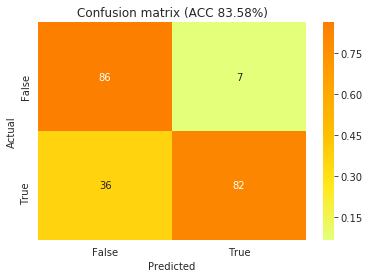

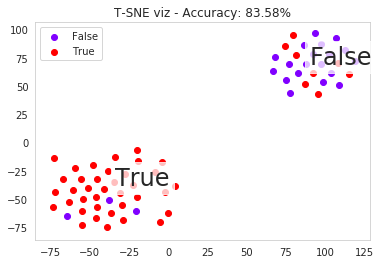

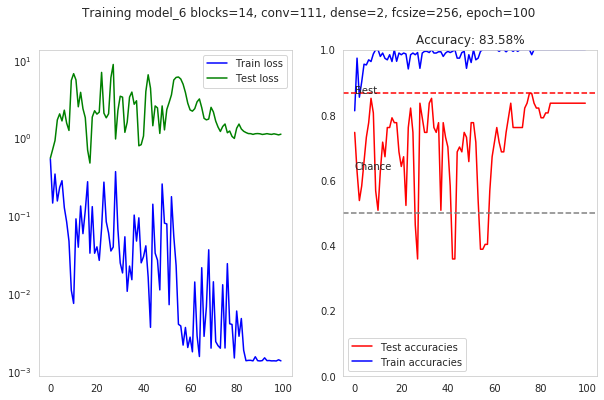

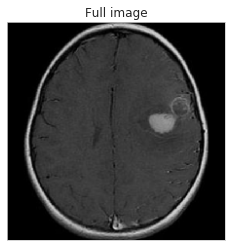

/home/gje1631/.conda/envs/tf_gpu2/lib/python3.7/site-packages/skimage/exposure/exposure.py:351: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)


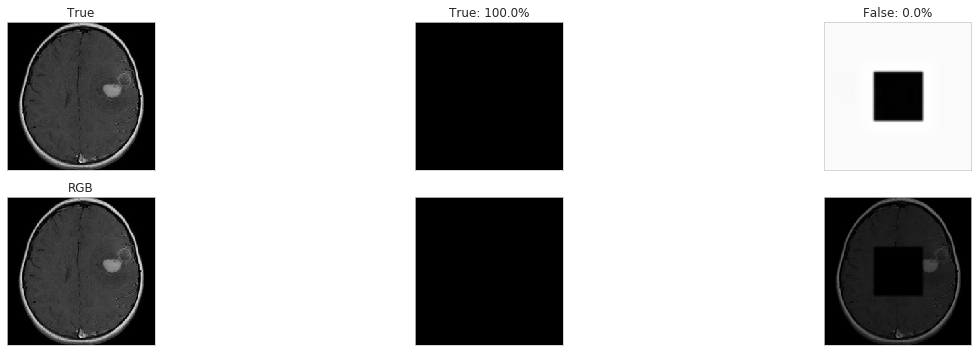

Actual: True(1)
    predicted:       True(1), confidence=1.00 [********* ]
    predicted:      False(0), confidence=0.00 [          ]
Total training time: 30.85 min, epoch: 100
Average time per epoch: 18.51 s


In [146]:
#%% Training code
##transfer learning
from IPython.display import clear_output

tm = time.time()
trainstats = pd.DataFrame(columns=('Train loss', 'Test loss', 'Accuracy', 'Train accuracy'))
epochs=100 ####change

from keras.callbacks import Callback

loss = model.fit_generator(
    train_generator,
    steps_per_epoch=int(len(train_generator.filenames)/batch_size),
    validation_data=(X_test, Y_test),
    validation_steps=1,
    verbose=1, epochs=epochs,
    use_multiprocessing=True,
    workers=4,
    callbacks=[VizTraining()]
)

In [ ]:
# loss

